### Purpose and description of this notebook 

In [ ]:
from shapely.geometry import Polygon, Point
import geopandas
import numpy as np
import os
import matplotlib.pylab as plt

In [52]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
print(type(eco_shp))
print(eco_shp.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'proj': 'laea', 'lat_0': 45, 'lon_0': -100, 'x_0': 0, 'y_0': 0, 'a': 6370997, 'b': 6370997, 'units': 'm', 'no_defs': True}


In [59]:
eco_reprojected = eco_shp.to_crs({'init': '+init=epsg:4326'})

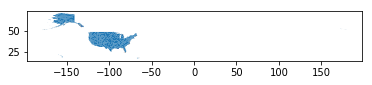

In [58]:
eco_reprojected.plot()

In [151]:
from netCDF4 import Dataset
cmip_dir = os.path.join('..','Data','CMIP5','r1i1p1_rcp45_rcp85_merged_t_COMMON_GRID', 'tas_Amon_NorESM1-M_rcp45_r1i1p1_200601-210012.nc')
cmip = Dataset(cmip_dir,'r')
lat = cmip.variables['lat'][:]
lon = cmip.variables['lon'][:] - 180. # Will be reprojected using CDO
tas = cmip.variables['tas'][:]
cmip.close()

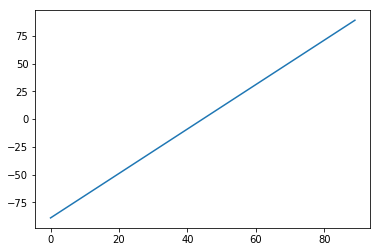

In [155]:
plt.plot(lat)

In [70]:
dx = np.unique(np.diff(lon))
print(dx)
dy = np.unique(np.diff(lat))
print(dy)

[2.5]
[2.]


In [85]:
# Make polygons that describe the global grid
grid_polygons = []

for i in range(len(lon)) :
    for j in range(len(lat)) :
        
        x_center = lon[i]
        y_center = lat[j]
        
        x0 = x_center - dx/2.
        x1 = x_center + dx/2.
        y0 = y_center - dy/2.
        y1 = y_center + dy/2.
        
        grid_box_poly = Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])
        
        grid_polygons.append(grid_box_poly)


grid_geo = geopandas.GeoSeries(grid_polygons)

In [86]:
len(grid_polygons)

12960

In [89]:
# Make a GeoDataFrame
grid_geo_df = geopandas.GeoDataFrame({'geometry':grid_polygons, 'grid_ID': np.arange(len(grid_polygons))})
# CRS projection to assign to grid boxes when made into polygons
crs_to_assign = {'init': '+init=epsg:4326'}
grid_geo_df.crs = crs_to_assign

In [90]:
# Get world land mass file and set to the same crs 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_df = world.to_crs(crs_to_assign)

<Figure size 600x400 with 0 Axes>

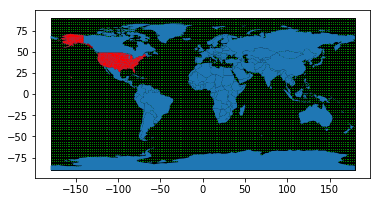

In [93]:
plt.figure(dpi=100)
base = grid_geo_df.plot(edgecolor='black', color="green")
world_df.plot(ax=base)
eco_reprojected.plot(ax=base, color='red')
plt.show()

In [94]:
overlap = geopandas.overlay(grid_geo_df, world_df, how='intersection')
# The grid_ID that show up in overlap are the ones I need to flag as overlapping land. 


In [109]:
overlap.columns

Index(['grid_ID', 'pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est',
       'geometry'],
      dtype='object')

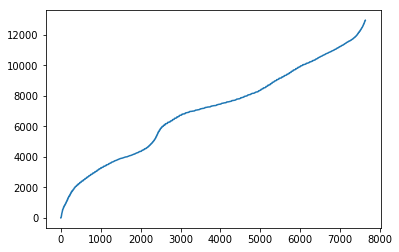

In [130]:
unique_overlapping_grid_IDs = np.array(overlap.grid_ID.copy())
plt.plot(np.sort(unique_overlapping_grid_IDs))

In [117]:
print(len(overlapping_grid_IDs))
print(len(np.unique(overlapping_grid_IDs)))

7636
5322


In [106]:
print(grid_geo_df.columns)
print(world_df.columns)

Index(['geometry', 'grid_ID'], dtype='object')
Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


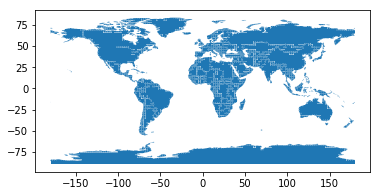

In [103]:
overlap.plot()

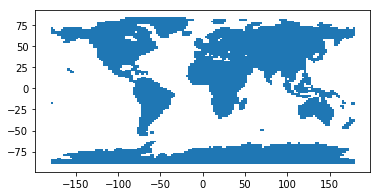

In [121]:
grid_geo_df.iloc[unique_overlapping_grid_IDs,:].plot()

In [137]:
np.sum(120000==overlapping_grid_IDs)

0

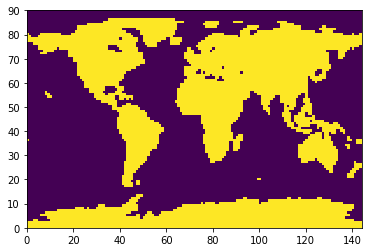

In [142]:
# Translate back to the original lat lon grid 
land_mask = np.zeros((len(lat), len(lon)), dtype=int)
count = 0
for i in range(len(lon)) :
    for j in range(len(lat)) :
        n_in_array = np.sum(count == overlapping_grid_IDs)
        if n_in_array > 0 :
            land_mask[j,i] = 1
        count += 1
        
plt.pcolor(land_mask)

In [157]:
# Write this land mask as a netcdf file 
outputFile = os.path.join("..","Data","LandCover", "land_mask.nc")
outputFileCommonGrid = os.path.join("..","Data","LandCover", "common_grid_land_mask.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'Land mask according to netcdf grid box overlap with naturalearth_lowres grom geopandas'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(lat) )
ncFile.createDimension('longitude', len(lon) )

# Create data variables
VAR_ = ncFile.createVariable("land_mask", 'f4',('latitude','longitude'))
VAR_.units = "1=land, 0=not land"

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"
#longitude_.lon_bnds = lon_bnds

# Write the actual data to these dimensions
VAR_[:]       = land_mask[:]
latitude_[:]  = np.array(lat)
longitude_[:] = np.array(lon)
ncFile.close()

# And use cdo to make a common grid version 
import cdo as cdo
cdo = cdo.Cdo()

common_grid_file = os.path.join("..","Data","LandCover",'COMMON_GRID.txt')
cdo.remapbil(common_grid_file, input=outputFile, output=outputFileCommonGrid, options="-b F64")

'../Data/LandCover/common_grid_land_mask.nc'